In [3]:
import pandas as pd
import numpy as np


In [4]:
from datetime import datetime
import boto3
from botocore.exceptions import ClientError
from io import StringIO
import re
# from fastparquet import ParquetFile
# import s3fs
# from cleodata.utils.secrets import get_secret
# from cleodata.sources.sync.sync import SyncDataSource
# boto3.setup_default_session(profile_name='DataScientist-878877078763')
# redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [5]:
from sagemaker import get_execution_role
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [6]:
def read_from_s3(path):
    """Read parquet files and combine them into a single dataframe"""
    fs = s3fs.core.S3FileSystem()
    all_paths_from_s3 = fs.glob(path=f"{path}*.parquet")

    if len(all_paths_from_s3) > 0:
        s3 = s3fs.S3FileSystem()
        fp_obj = ParquetFile(
            all_paths_from_s3, open_with=s3.open
        )  # use s3fs as the filesystem
        data = fp_obj.to_pandas()
        return data
    elif len(all_paths_from_s3)==1:
        return pd.read_parquet(all_paths_from_s3[0])
    else:
        print(f"Nothing found")
        print(f"paths from a{all_paths_from_s3}")
    
def read_csv_s3(bucket, key):
    try:
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'])
        return df
    except ClientError as ex:
        if ex.response['Error']['Code'] == 'NoSuchKey':
            print("Key doesn't match. Please check the key value entered.")


# Create positive and negative data pairs

In [7]:
%pip install pyarrow
%pip install fastparquet
%pip install awswrangler

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import awswrangler as wr

In [9]:
path_new_file = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed_duplicates/trans_2024-05-15_2024-05-15"
df_data_raw = wr.s3.read_parquet(path=path_new_file)

In [10]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel,currency_code,is_duplicate,original_merchant_name_combined
0,9795191827,2024-05-15,393.0,VENMO*Beagley Alicia New York City NY,Venmo,VENMO*Beagley Alicia New York City NY,VENMO*Beagley Alicia New York City NY. Channel...,VENMO*Beagley Alicia New York City NY. Type: p...,other,USD,0,Venmo
1,9795238129,2024-05-15,-50.0,Transfer From Varo Bank Account To Varo Saving...,Savings,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,other,USD,0,Savings
2,9795238126,2024-05-15,87.1,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,Lyft,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Channel: ...,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Type: mer...,other,USD,0,Lyft
3,9795262319,2024-05-15,55.0,Transfer from Chime Savings Account,Savings,Transfer from Chime Savings Account,Transfer from Chime Savings Account. Channel: ...,Transfer from Chime Savings Account. Type: fin...,other,USD,0,Savings
4,9795270652,2024-05-15,28.8,Transfer from Wallet,Wallet,Transfer from Wallet,Transfer from Wallet. Channel: None. Amount: 28.8,Transfer from Wallet. Type: . Channel: None. A...,other,USD,0,Wallet


In [11]:
# path_new_file = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-14_2024-05-14"
# df_data_raw = wr.s3.read_parquet(path=path_new_file)

In [12]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel,currency_code,is_duplicate,original_merchant_name_combined
0,9795191827,2024-05-15,393.0,VENMO*Beagley Alicia New York City NY,Venmo,VENMO*Beagley Alicia New York City NY,VENMO*Beagley Alicia New York City NY. Channel...,VENMO*Beagley Alicia New York City NY. Type: p...,other,USD,0,Venmo
1,9795238129,2024-05-15,-50.0,Transfer From Varo Bank Account To Varo Saving...,Savings,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,other,USD,0,Savings
2,9795238126,2024-05-15,87.1,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,Lyft,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Channel: ...,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Type: mer...,other,USD,0,Lyft
3,9795262319,2024-05-15,55.0,Transfer from Chime Savings Account,Savings,Transfer from Chime Savings Account,Transfer from Chime Savings Account. Channel: ...,Transfer from Chime Savings Account. Type: fin...,other,USD,0,Savings
4,9795270652,2024-05-15,28.8,Transfer from Wallet,Wallet,Transfer from Wallet,Transfer from Wallet. Channel: None. Amount: 28.8,Transfer from Wallet. Type: . Channel: None. A...,other,USD,0,Wallet


In [13]:
#df_data_raw[df_data_raw['merchant_name_combined'] == 'Myfico']

In [14]:
path_file_out = path_new_file.split('processed_duplicates/')[0]+'trx-merchant-pair/'+path_new_file.split('processed_duplicates/')[1]
path_file_out

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-15_2024-05-15'

In [15]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel,currency_code,is_duplicate,original_merchant_name_combined
0,9795191827,2024-05-15,393.0,VENMO*Beagley Alicia New York City NY,Venmo,VENMO*Beagley Alicia New York City NY,VENMO*Beagley Alicia New York City NY. Channel...,VENMO*Beagley Alicia New York City NY. Type: p...,other,USD,0,Venmo
1,9795238129,2024-05-15,-50.0,Transfer From Varo Bank Account To Varo Saving...,Savings,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,other,USD,0,Savings
2,9795238126,2024-05-15,87.1,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,Lyft,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Channel: ...,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Type: mer...,other,USD,0,Lyft
3,9795262319,2024-05-15,55.0,Transfer from Chime Savings Account,Savings,Transfer from Chime Savings Account,Transfer from Chime Savings Account. Channel: ...,Transfer from Chime Savings Account. Type: fin...,other,USD,0,Savings
4,9795270652,2024-05-15,28.8,Transfer from Wallet,Wallet,Transfer from Wallet,Transfer from Wallet. Channel: None. Amount: 28.8,Transfer from Wallet. Type: . Channel: None. A...,other,USD,0,Wallet


In [16]:
print(df_data_raw['sentence'][1000050], df_data_raw['merchant_name_combined'][1000050])

Checking Withdrawal @ AR Bentonville Walmart.com USWalmart.com Trace # . Channel: online. Amount: -207.6 Walmart


In [17]:
df_data_raw['num_words'] = df_data_raw['description_combined_processed'].apply(lambda x: len(x.split(' ')))

In [18]:
df_data_raw['num_words'].describe()

count    1.899541e+06
mean     8.163171e+00
std      3.859636e+00
min      1.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      4.100000e+01
Name: num_words, dtype: float64

In [19]:
df_data_raw['num_words'].max()*3

123

In [20]:
df_data_raw[df_data_raw['num_words']==41]

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel,currency_code,is_duplicate,original_merchant_name_combined,num_words
353521,9800029629,2024-05-15,70.0,"Katherine Styczenski \""Read your messages I''l...",Venmo,"Katherine Styczenski \""Read your messages I''l...","Katherine Styczenski \""Read your messages I''l...","Katherine Styczenski \""Read your messages I''l...",other,USD,0,Venmo,41
1438248,9819221926,2024-05-15,-3383.5,"Debit for $3,383.50, an item was processed mor...",Debit For Duplicate Deposit,"Debit for $3,383.50, an item was processed mor...","Debit for $3,383.50, an item was processed mor...","Debit for $3,383.50, an item was processed mor...",in store,USD,0,Debit For Duplicate Deposit,41


In [21]:

df_data_raw.loc[1600443,'description_combined_processed']

'PURCHASE BROOKLYN BAGELS WHITEH'

In [22]:
df_data_raw.loc[1600443,'description_combined']

'PURCHASE BROOKLYN BAGELS WHITEH'

In [23]:
df_data_raw.loc[1600443,'merchant_name_combined']

'Brooklyn Bagel'

In [24]:
df_data_raw['len_sentence'] = df_data_raw['description_combined_processed'].apply(lambda x: len(x.split(' ')))

In [25]:
df_data_raw['len_sentence'].max()

41

In [26]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel,currency_code,is_duplicate,original_merchant_name_combined,num_words,len_sentence
0,9795191827,2024-05-15,393.0,VENMO*Beagley Alicia New York City NY,Venmo,VENMO*Beagley Alicia New York City NY,VENMO*Beagley Alicia New York City NY. Channel...,VENMO*Beagley Alicia New York City NY. Type: p...,other,USD,0,Venmo,6,6
1,9795238129,2024-05-15,-50.0,Transfer From Varo Bank Account To Varo Saving...,Savings,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,Transfer From Varo Bank Account To Varo Saving...,other,USD,0,Savings,9,9
2,9795238126,2024-05-15,87.1,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,Lyft,LYFT *XPAY DEPOSIT SAN FRANCISCO CA,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Channel: ...,LYFT *XPAY DEPOSIT SAN FRANCISCO CA. Type: mer...,other,USD,0,Lyft,6,6
3,9795262319,2024-05-15,55.0,Transfer from Chime Savings Account,Savings,Transfer from Chime Savings Account,Transfer from Chime Savings Account. Channel: ...,Transfer from Chime Savings Account. Type: fin...,other,USD,0,Savings,5,5
4,9795270652,2024-05-15,28.8,Transfer from Wallet,Wallet,Transfer from Wallet,Transfer from Wallet. Channel: None. Amount: 28.8,Transfer from Wallet. Type: . Channel: None. A...,other,USD,0,Wallet,3,3


In [36]:
df_data_raw['merchant_name_combined_len'] = df_data_raw['merchant_name_combined'].apply(lambda x: len(x))
df_data_raw = df_data_raw[df_data_raw['merchant_name_combined_len']>=1]
df_data_raw.drop('merchant_name_combined_len', axis=1, inplace=True)


In [37]:
print(df_data_raw[df_data_raw['len_sentence']==df_data_raw['len_sentence'].max()]['description_combined'])

353521     Katherine Styczenski \"Read your messages I''l...
1438248    Debit for $3,383.50, an item was processed mor...
Name: description_combined, dtype: string


In [38]:
df_merchant_volume = df_data_raw['merchant_name_combined'].value_counts(dropna=False).to_frame()
df_merchant_volume

,count
merchant_name_combined,
Earnin,91501
Savings,50347
Amazon,39677
Online Banking Transfer,36407
McDonald''s,36031
...,...
Coffee Cravings W Poplar,1
I Love Wings,1
Greene,1


In [39]:
n_tot_trans  = df_data_raw.shape[0]
df_merchant_volume['perc_traffic'] = df_merchant_volume['count']/n_tot_trans
df_merchant_volume.sort_values(by='perc_traffic', ascending=False)
df_merchant_volume['cumulative_traffic'] = df_merchant_volume['perc_traffic'].cumsum()
df_merchant_volume

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Earnin,91501,0.048929,0.048929
Savings,50347,0.026923,0.075852
Amazon,39677,0.021217,0.097069
Online Banking Transfer,36407,0.019468,0.116537
McDonald''s,36031,0.019267,0.135804
...,...,...,...
Coffee Cravings W Poplar,1,0.000001,0.999998
I Love Wings,1,0.000001,0.999998
Greene,1,0.000001,0.999999


In [43]:
df_merchant_volume

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Earnin,91501,0.048929,0.048929
Savings,50347,0.026923,0.075852
Amazon,39677,0.021217,0.097069
Online Banking Transfer,36407,0.019468,0.116537
McDonald''s,36031,0.019267,0.135804
...,...,...,...
Coffee Cravings W Poplar,1,0.000001,0.999998
I Love Wings,1,0.000001,0.999998
Greene,1,0.000001,0.999999


(0.0, 4000.0)

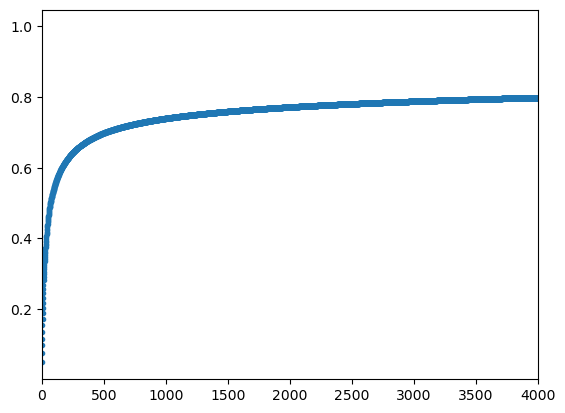

In [45]:
import matplotlib.pyplot as plt
plt.plot(np.arange(df_merchant_volume.shape[0]),df_merchant_volume['cumulative_traffic'],'.')
plt.xlim([0,4000])

In [46]:
df_merchant_volume.reset_index(drop=False,inplace=True)
df_merchant_volume[0:10]

,merchant_name_combined,count,perc_traffic,cumulative_traffic
0,Earnin,91501,0.048929,0.048929
1,Savings,50347,0.026923,0.075852
2,Amazon,39677,0.021217,0.097069
3,Online Banking Transfer,36407,0.019468,0.116537
4,McDonald''s,36031,0.019267,0.135804
5,Empower,35527,0.018998,0.154802
6,Walmart,33387,0.017853,0.172656
7,Brigit,28746,0.015372,0.188027
8,MoneyLion,28461,0.015219,0.203247
9,Apple,27276,0.014586,0.217832


In [81]:
top_n = 10000
merchants_top_n = df_merchant_volume['merchant_name_combined'][0:top_n].tolist()
print(len(merchants_top_n))
merchants_top_n

10000


['Earnin',
 'Savings',
 'Amazon',
 'Online Banking Transfer',
 "McDonald''s",
 'Empower',
 'Walmart',
 'Brigit',
 'MoneyLion',
 'Apple',
 'Cleo',
 'Venmo',
 'Albert',
 'Dave Inc',
 'Cash Withdrawal',
 'Circle K',
 'Shell',
 'Dollar General',
 'Uber',
 '7 Eleven',
 'Affirm',
 'Amazon Prime',
 'Klarna',
 'Starbucks',
 'Target',
 'Klover',
 'Cash App',
 'Paypal',
 'Taco Bell',
 'Chick-fil-A',
 'QuikTrip',
 'BP',
 'FloatMe',
 'Afterpay',
 'Walgreens',
 "Dunkin'' Donuts",
 'Chevron',
 'Uber Eats',
 'Doordash',
 'Sezzle',
 'Speedway',
 'Lyft',
 "Wendy''s",
 'Zip In',
 'Fan Duel Sportsbook',
 'Dollar Tree',
 'Kroger',
 'Wawa',
 'Bank of America ATM',
 'Burger King',
 'CVS Pharmacy',
 '365 Markets',
 'Publix',
 'Overdraft Charge',
 'Wells Fargo',
 'Draftkings',
 'Family Dollar',
 'ExxonMobil',
 'Sunoco',
 'Bank of America - Keep the Change',
 'Dave',
 'Grid',
 'T-Mobile',
 'Netflix',
 'Possible Finance',
 'Sheetz',
 'Cash App Transfer',
 'Food Lion',
 'Subway',
 'Sonic',
 'Safeway',
 "Casey''s

In [79]:
15*1000/3600

4.166666666666667

In [50]:
20*50/3600

0.2777777777777778

In [51]:
166/60

2.7666666666666666

In [52]:
18*60*10*5/3600

15.0

In [53]:
# !pwd
# !ls -ltr /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History
# !more /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/14a6abb3/entries.json
# !touch /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/
# !touch /home/sagemaker-user/toto
# !echo "abdc" > /home/sagemaker-user/toto
# !more /home/sagemaker-user/toto

In [54]:
#!pip install path

In [55]:
from path import Path

In [83]:
top_tx_merchants = df_merchant_volume[df_merchant_volume['count']>max_rows_per_type]['merchant_name_combined'].tolist()
top_tx_merchants

['Earnin',
 'Savings',
 'Amazon',
 'Online Banking Transfer',
 "McDonald''s",
 'Empower',
 'Walmart',
 'Brigit',
 'MoneyLion',
 'Apple',
 'Cleo',
 'Venmo',
 'Albert',
 'Dave Inc',
 'Cash Withdrawal',
 'Circle K',
 'Shell']

In [84]:
df_top = df_data_raw[df_data_raw['merchant_name_combined'].isin(top_tx_merchants)]
df_not_top = df_data_raw[~df_data_raw['merchant_name_combined'].isin(top_tx_merchants)]

In [85]:
n_pairs = 5000
max_rows_per_type = 3*n_pairs
sampled_df = df_top.groupby('merchant_name_combined').apply(lambda x: x.sample(min(len(x), max_rows_per_type))).reset_index(drop=True)
  

In [86]:
df_all_sampled = pd.concat([sampled_df,df_not_top], axis=0)

In [88]:
#This step needs to be parallelized
df_all = pd.DataFrame()
for i,merchant in enumerate(merchants_top_n):
  #print(i,merchant)
  df_s1 = df_all_sampled[df_all_sampled['merchant_name_combined']==merchant][['transaction_id','sentence','sentence2',\
    'description_combined_processed',\
    'merchant_name_combined','is_duplicate','original_merchant_name_combined','amount']]
  df_s1.rename(columns={'merchant_name_combined':'true_merchant_name_combined'}, inplace=True)

  df_s2 = df_all_sampled[df_all_sampled['merchant_name_combined']!=merchant][['transaction_id','merchant_name_combined']]
  
  df_negative = pd.concat([df_s1.sample(min(df_s1.shape[0],2*n_pairs),random_state=1)[['transaction_id','sentence','sentence2',\
    'description_combined_processed','true_merchant_name_combined','is_duplicate','original_merchant_name_combined','amount']].reset_index(drop=True), \
                           df_s2.sample(min(df_s1.shape[0],2*n_pairs), random_state=1)[['merchant_name_combined']].reset_index(drop=True)], axis=1 , ignore_index=True)
  df_negative['true_label'] = 0
  df_negative['label'] = 0 + np.abs(np.random.normal(0,0.2,[1,df_negative.shape[0]])[0])
  df_negative.columns = ['transaction_id','sentence','sentence2','description_combined_processed','true_merchant_name_combined',\
   'is_duplicate','original_merchant_name_combined','amount', 'merchant_name_combined','true_label','label']
  df_positive = df_s1.sample(min(df_s1.shape[0],n_pairs), random_state=1)
  df_positive['true_label'] = 1
  df_positive['label'] = 1 - np.abs(np.random.normal(0,0.2,[1,df_positive.shape[0]])[0])
  df_positive['merchant_name_combined'] = df_positive['true_merchant_name_combined']
  df_all = pd.concat([df_all, df_negative, df_positive[['transaction_id','sentence','sentence2','description_combined_processed',\
    'true_merchant_name_combined','is_duplicate','original_merchant_name_combined','amount','merchant_name_combined','true_label','label']] ], axis=0)
  #!echo "abdc" > /home/sagemaker-user/toto
  if i%100 == 0:
    print(i,merchant)
    Path("/opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/reset_timer.txt").touch()
  if i%1000 == 0:
    print('saving')
    print(i)
    s3_path_out = path_file_out+'_top_'+str(top_n)+'_'+str(i)+'.parquet'
    #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sample.parquet"
    #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/transactions_2024-05-20_2024-05-20_"+str(i)+".parquet"
    #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sm_test.parquet"
    df_all.to_parquet(s3_path_out, engine='pyarrow')
    print(i, s3_path_out)


s3_path_out = path_file_out+'_top_'+str(top_n)+'.parquet'
df_all.to_parquet(s3_path_out, engine='pyarrow')


0 Earnin
saving
0
0 s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-15_2024-05-15_top_10000_0.parquet


KeyboardInterrupt: 

In [ ]:
# s3_path_out = path_file_out+'_top_'+str(top_n)+'.parquet'
# df_all.to_parquet(s3_path_out, engine='pyarrow')
print(f"Finished creating {s3_path_out}")
df_data_pairs = wr.s3.read_parquet(path=s3_path_out)


Finished creating s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-13_2024-05-13_top_101.parquet


In [ ]:
Path("/opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/reset_timer.txt").touch()

In [ ]:
  # s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/transactions_2024-05-20_2024-05-20_top5K.parquet"
  # #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sm_test.parquet"
  # df_all.to_parquet(s3_path_out, engine='pyarrow')

In [ ]:
print("finished")

finished


In [ ]:
df_all.reset_index(drop=True, inplace=True)

In [ ]:
df_all.head()

,transaction_id,sentence,sentence2,merchant_name_combined,true_label,label
0,9856397567,Cash App*Katelyn Vega Channel: None. Amount: -...,Cash App*Katelyn Vega Type: payment_app Channe...,McDonald''s,0,0.122509
1,9860053436,MONEY TRANSFER AUTHORIZED ON 05/19 CASH APP*ST...,MONEY TRANSFER AUTHORIZED ON 05/19 CASH APP*ST...,Walmart,0,0.127154
2,9849592429,Check Card Debit CASH APP*DESTINEE CHAR SAN F...,Check Card Debit CASH APP*DESTINEE CHAR SAN F...,Uber,0,0.137196
3,9862154091,CASH APP*WILLIAM PRICE* San FranciscoCA Channe...,CASH APP*WILLIAM PRICE* San FranciscoCA Type: ...,Brigit,0,0.274984
4,9860580476,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*RA...,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*RA...,Round Up,0,0.233289


In [ ]:
df_all.loc[0,'sentence']

'Cash App*Katelyn Vega Channel: None. Amount: -30.00'

In [ ]:
df_all.loc[0,'sentence2']

'Cash App*Katelyn Vega Type: payment_app Channel: None. Amount: -30.00'

In [ ]:
# df_all.to_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20_sample_top5K_pairs.csv")

In [ ]:
print(f"Finished creating file")

Finished creating file


In [ ]:
#write this data to s3

In [ ]:
df_all.head(20)

,transaction_id,sentence,merchant_name_combined,true_label,label
0,9861390363,CHECKCARD 0517 CASH APP*MARIO*AD XXXXX91940 CA...,Food Lion,0,0.060653
1,9863465715,Cash App Transfer to Christoph other 0 ...,Zealchurch.co,0,0.014648
2,9869624532,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*TA...,Publix,0,0.011352
3,9868732447,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*ZI...,RaceTrac,0,0.401207
4,9851739256,Cash app*um daddy*cash san franciscocaus other...,AfterPay,0,0.010773
5,9861987135,Transfer from Cash App other 0 25.00...,MoneyLion,0,0.117875
6,9859650459,3836 CASH APP*SILVESTER F52 San Francisco CA 9...,Dollar Tree,0,0.031189
7,9862651079,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*JO...,Albert,0,0.165105
8,9864106688,CASH APP*CRYSTAL WAR SAN FRANCISCO CA256098 05...,Chatur,0,0.450697
9,9861917121,"DEBIT CARD PURCHASE AT CASH APP*MATTHEW R, SAN...",Tree House,0,0.003653
